In [1]:
import os
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
%matplotlib inline

In [2]:
hp.disable_warnings()

In [3]:
plt.style.use("seaborn-talk")

In [4]:
import pysm3 as pysm
import pysm3.units as u

In [5]:
lmax = 1000
nside = 2048

In [6]:
import pymaster as nmt

In [7]:
binning = nmt.NmtBin(nside=nside, nlb=1, lmax=lmax, is_Dell=True)

In [8]:
ell = binning.get_effective_ells()

In [9]:
def run_namaster(m, mask):
    """Run NaMaster for a QU map
    
    uses a binning object defined globally"""
    f_2 = nmt.NmtField(mask, m)   
    cl_namaster = nmt.compute_full_master(f_2, f_2, binning)
    return cl_namaster[0], cl_namaster[3]

## Mask

In [10]:
planck_mask_filename = "COM_Mask_CMB-common-Mask-Pol_2048_R3.00.fits"

In [11]:
planck_mask = hp.read_map(planck_mask_filename)

## Load original GNILC map at uniform resolution

In [12]:
dust_map_smoothed_filename = "COM_CompMap_IQU-thermaldust-gnilc-unires_2048_R3.00.fits"

In [14]:
KCMB_to_uKRJ = (1*u.K_CMB).to("uK_RJ", equivalencies=u.cmb_equivalencies(353*u.GHz))

In [15]:
KCMB_to_uKRJ

<Quantity 77486.36962953 uK_RJ>

In [56]:
m_planck_smoothed = hp.read_map(dust_map_smoothed_filename, ("Q_STOKES", "U_STOKES")) * KCMB_to_uKRJ.value

In [16]:
cl_planck_smoothed= run_namaster(m_planck_smoothed, planck_mask)

In [17]:
cl_planck_smoothed = np.array(cl_planck_smoothed)

In [18]:
hp.write_cl("compare_cl_gnilc_smoothed.fits", cl_planck_smoothed, overwrite=True)

In [19]:
# cl_planck_smoothed = hp.read_cl("compare_cl_gnilc_smoothed.fits")

## Load original GNILC map at variable resolution

In [20]:
dust_map_filename = "COM_CompMap_IQU-thermaldust-gnilc-varres_2048_R3.00.fits"

In [61]:
m_planck = hp.read_map(dust_map_filename, ("Q_STOKES", "U_STOKES")) * KCMB_to_uKRJ

In [24]:
cl_planck = run_namaster(m_planck, planck_mask)

In [25]:
cl_planck = np.array(cl_planck)

In [26]:
hp.write_cl("compare_cl_gnilc.fits", cl_planck, overwrite=True)

In [27]:
# cl_planck = hp.read_cl("compare_cl_gnilc.fits")

## Load the GNILC templates with added small scales

In [28]:
m_template = hp.read_map("gnilc_plus_smallscales.fits", (1,2))

In [29]:
cl_template = run_namaster(m_template, planck_mask)

In [30]:
hp.write_cl("compare_cl_template.fits", cl_template, overwrite=True)

In [31]:
# cl_template = hp.read_cl("compare_cl_template.fits")

In [32]:
m_template_scaled = hp.read_map("gnilc_plus_smallscales_scaled.fits", (1,2))

In [33]:
cl_template_scaled = run_namaster(m_template_scaled, planck_mask)

In [34]:
hp.write_cl("compare_cl_template_scaled.fits", cl_template_scaled, overwrite=True)

In [35]:
# cl_template_scaled = hp.read_cl("compare_cl_template_scaled.fits")

## Download PySM 2 templates

In [36]:
for comp in "tqu":
    filename = f"dust_{comp}_new.fits"
    if not os.path.exists(filename):
        !wget https://portal.nersc.gov/project/cmb/pysm-data/pysm_2/$filename

In [37]:
m_pysm2 = [hp.read_map(f"dust_{comp}_new.fits") for comp in "qu"]

In [38]:
cl_pysm2 = run_namaster(m_pysm2, hp.ud_grade(planck_mask, 512) == 1)

## Compare PySM 2, the input and the output

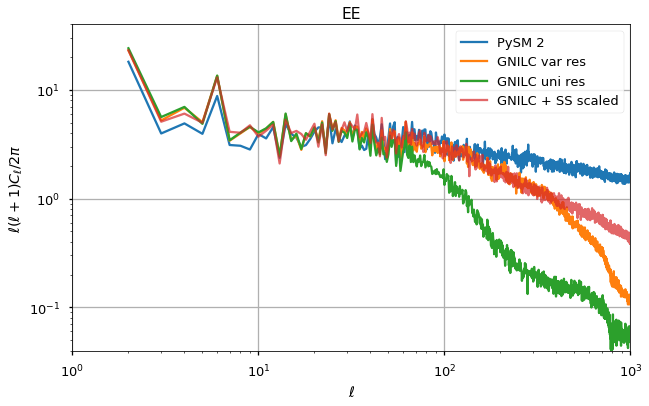

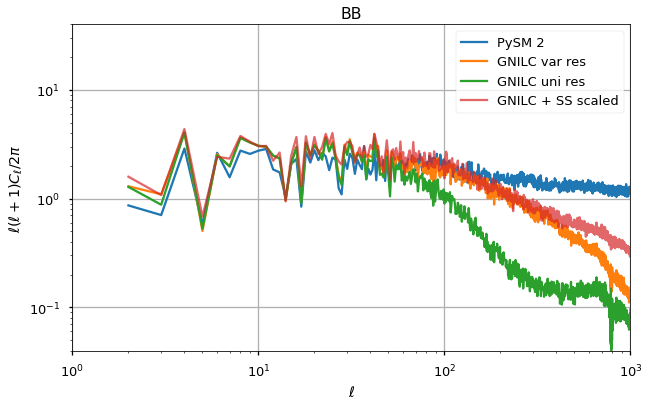

In [39]:
for pol, i_pol in [("EE",0),("BB",1)]:
    plt.figure(figsize=(10,6))
    plt.loglog(ell, cl_pysm2[i_pol], label="PySM 2")

    plt.loglog(ell, cl_planck[i_pol], label="GNILC var res")
    plt.loglog(ell, cl_planck_smoothed[i_pol], label="GNILC uni res")
    #plt.loglog(ell, cl_template[i_pol], label="GNILC + SS")
    plt.loglog(ell, cl_template_scaled[i_pol], alpha=.7, label="GNILC + SS scaled")
    #plt.loglog(A_fit[pol] * ell**gamma_fit[pol], label="spectrum fit")
    #plt.axvline(ell_star, color="black")
    plt.title(pol)
    plt.legend()
    plt.xlim([1,1000])
    plt.ylim([4e-2, 4e1])
    plt.ylabel("$\ell(\ell+1)C_\ell/2\pi$")
    plt.xlabel("$\ell$")
    plt.grid();

We can also compare with the dust BB plot (Figure 7) from the PySM 2 paper below

![BB Dust PySM 2 Paper](BB_dust_PySM_2_paper.png)

In [63]:
m_labels = [(m_planck, "GNILC var res"), (m_pysm2, "PySM 2"),
            (m_planck_smoothed, "GNILC uni res"), (m_template_scaled, "GNILC + SS scaled")]

## Inspect a region of the maps

As in the PySM 2 paper, see a gnomview centered at RA,DEC (0,-55), 40 degrees per side.

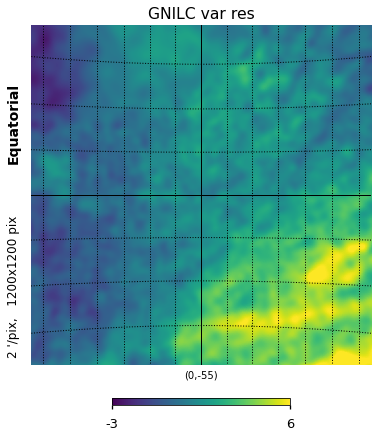

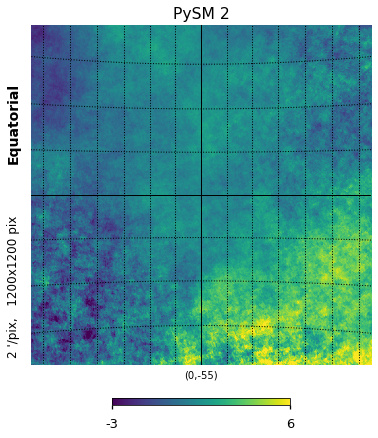

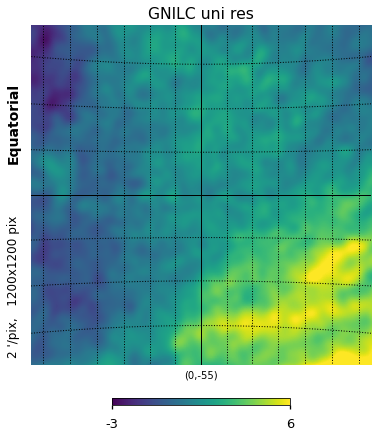

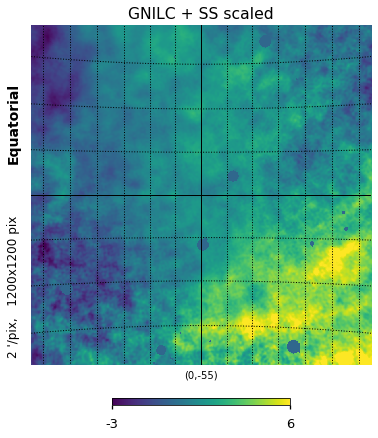

In [65]:
for m,label in m_labels:
    hp.gnomview(m[0],rot= (0,-55), xsize=1200, reso=2, coord=("G","C"),min=-3, max=6, title=label)
    hp.graticule()